In [1]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('seaborn')

In [3]:
exps = ['m4_finance_daily_hyper', 'm4_micro_daily_hyper', 'm4_macro_daily_hyper']
run_infos = {exp: [] for exp in exps}

for exp in exps:
    for run in os.listdir(exp):
        if '.ipynb' in run or '.json' in run: continue
        with open(f'{exp}/{run}/run_info.json', 'r') as file:
            run_infos[exp].append(json.load(file))

pprint(run_infos)

{'m4_finance_daily_hyper': [{'Avg. len of series': 1218.54,
                             'config input': {'dataset': {'cumulate used': 0,
                                                          'file name': 'm4_daily_finance.json',
                                                          'file path': 'datasets/',
                                                          'file type': 'json',
                                                          'max length': 1500,
                                                          'min length': 1000,
                                                          'use series': 50},
                                              'execution config': {'n of workers': 22},
                                              'modelling config': {'forecast horizon': 1,
                                                                   'gap': 0,
                                                                   'retrain window': 10,
                          

Load agents' run information

In [4]:
agent_infos_raw = {}

for exp, runs in run_infos.items():
    for run in runs:
        run_id = run['run time'][0]
        models = run['config input']['models']

        for m in models:
            if m == 'MA': continue
            agent_1 = f'{m}_raw'
            agent_2 = f'{m}_tran'

            if agent_1 not in agent_infos_raw:
                with open(f'{exp}/{run_id}/{agent_1}.json', 'r') as file:
                    agent_infos_raw[agent_1] = json.load(file)
            else:
                with open(f'{exp}/{run_id}/{agent_1}.json', 'r') as file:
                    agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}

            if agent_2 not in agent_infos_raw:
                with open(f'{exp}/{run_id}/{agent_2}.json', 'r') as file:
                    agent_infos_raw[agent_2] = json.load(file)
            else:
                with open(f'{exp}/{run_id}/{agent_2}.json', 'r') as file:
                    agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}


A list of agents we have in this analysis.

In [5]:
agent_infos_raw = dict( sorted(agent_infos_raw.items(), key=lambda x: x[0].lower()) )

list(agent_infos_raw.keys())

['EN_raw',
 'EN_tran',
 'ETS_raw',
 'ETS_tran',
 'LSVR_raw',
 'LSVR_tran',
 'MLP_raw',
 'MLP_tran',
 'RF_raw',
 'RF_tran']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [6]:
agent_fails = {k: [] for k in agent_infos_raw.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Get analysis only on the series played by all agents.

In [7]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print(f'{len(played_by_all)} series played by all agents: ')
print(played_by_all)

252 series played by all agents: 
{'2080', '2622', '129', '1356', '2577', '554', '1355', '594', '572', '14', '607', '2518', '2851', '3560', '2503', '2526', '601', '99', '3559', '2941', '2315', '3511', '120', '2440', '988', '122', '1', '3197', '116', '598', '644', '2078', '12', '1351', '591', '1361', '2625', '114', '3120', '1347', '642', '998', '652', '2214', '2998', '1345', '2779', '2041', '125', '582', '1357', '35', '2497', '1362', '603', '646', '2997', '3550', '651', '8', '3558', '633', '571', '3057', '2081', '1603', '101', '2623', '7', '33', '574', '100', '111', '1004', '119', '3358', '602', '643', '98', '3234', '610', '593', '2580', '3512', '640', '578', '31', '2317', '586', '130', '20', '106', '1349', '576', '2425', '2591', '3208', '994', '3551', '608', '2551', '1002', '3513', '579', '590', '16', '104', '3359', '2552', '2588', '3549', '105', '2621', '144', '653', '2137', '2310', '1350', '28', '2589', '1348', '3554', '2040', '11', '126', '3196', '2975', '580', '3235', '2756', '1005

In [8]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # large, filter keys

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

In [9]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 20,
}

## A glance at model prediction

Before digging into the details, take a quick look on how the models are doing on the tests. In this section, I manually took two time series that were played by all agents. One of the time series exhibits an exogeneous shock in the testing set.

In [10]:
# the time series
with open('m4_daily_dataset_see.json', 'r') as file:
    ts = json.load(file)

print(ts.keys())


dict_keys(['2590', '35', '600', '54', '593', '2576', '650', '3511', '607', '3548', '2975', '2315', '1355', '554', '596', '3469', '642', '577', '2044', '1603', '2625', '2902', '1351', '3120', '652', '653', '1349', '571', '102', '111', '14', '602', '645', '3359', '3358', '2622', '5', '3213', '1348', '594', '63', '2425', '1360', '2595', '608', '110', '130', '33', '13', '599', '1346', '633', '2580', '1361', '604', '99', '3357', '574', '6', '2753', '3470', '2432', '640', '991', '586', '2484', '2624', '117', '1362', '995', '3121', '118', '656', '32', '2551', '597', '2592', '609', '1350', '2756', '69', '2779', '2553', '2974', '2081', '573', '636', '2439', '603', '454', '3131', '3038', '610', '15', '3037', '1000', '34', '19', '578', '2485', '3212', '17', '601', '591', '657', '112', '1005', '2526', '2502', '606', '1359', '3196', '605', '993', '598', '1357', '2078', '641', '986', '3115', '1358', '590', '583', '2370', '2440', '3057', '100', '3235', '634', '3114', '1345'])


In [11]:
use = '35'

In [12]:
# filter out the test set

test_size = 0.1
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

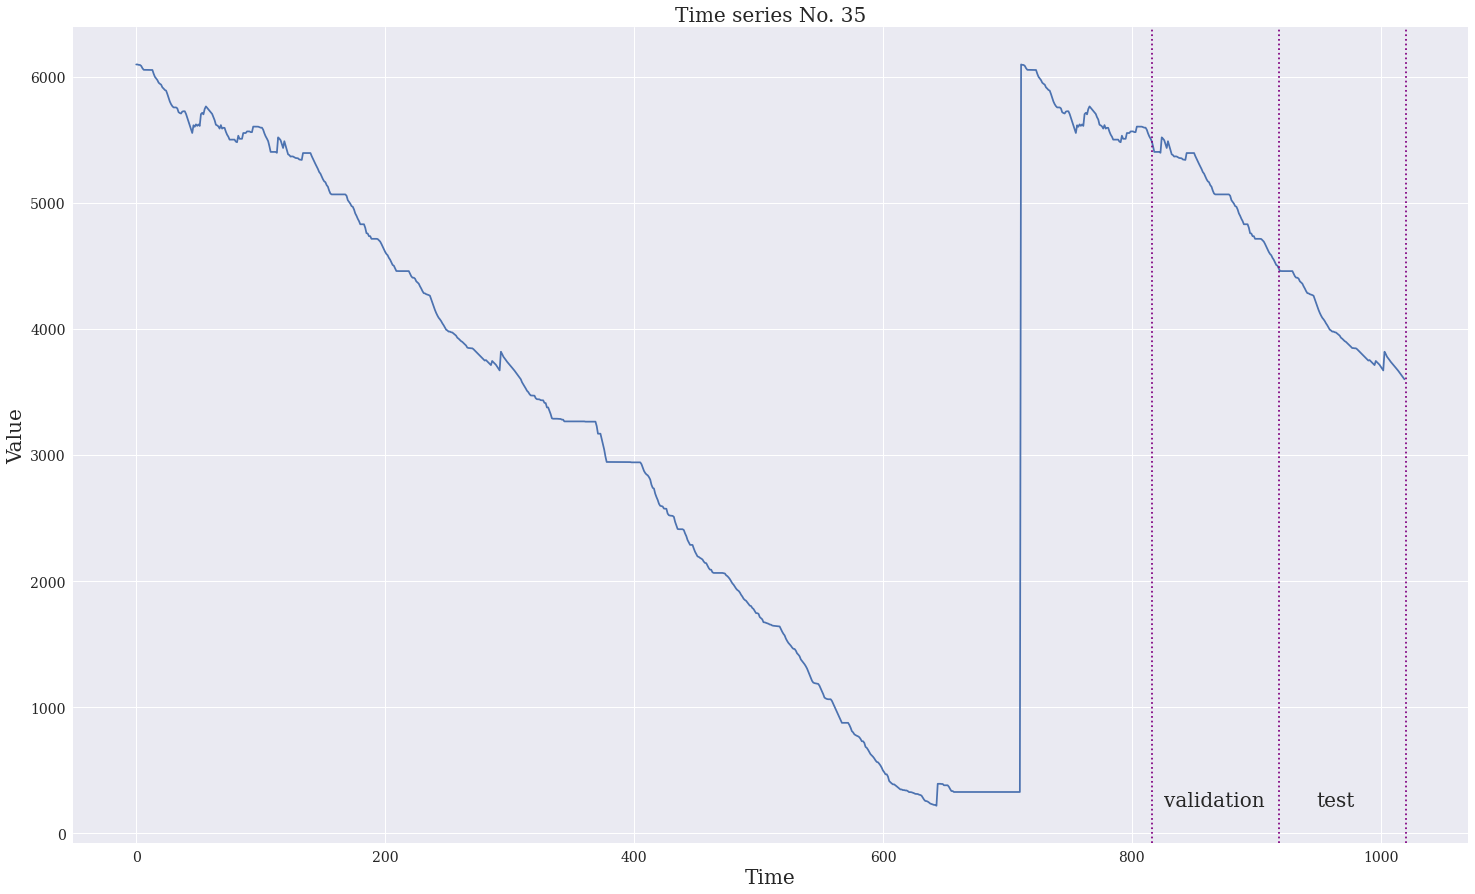

In [13]:
length = len(ts[use])

plt.figure(figsize=(25, 15))
plt.plot(ts[use])
plt.axvline(x=length-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count-test_set_count+10, min(ts[use]), 'validation', fontdict=font)
plt.axvline(x=length-test_set_count-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count+30, min(ts[use]), 'test', fontdict=font)
plt.axvline(x=length, ls=':', color='purple')
plt.title(f'Time series No. {use}', fontdict=font)
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

tran generates 29.8947% less error


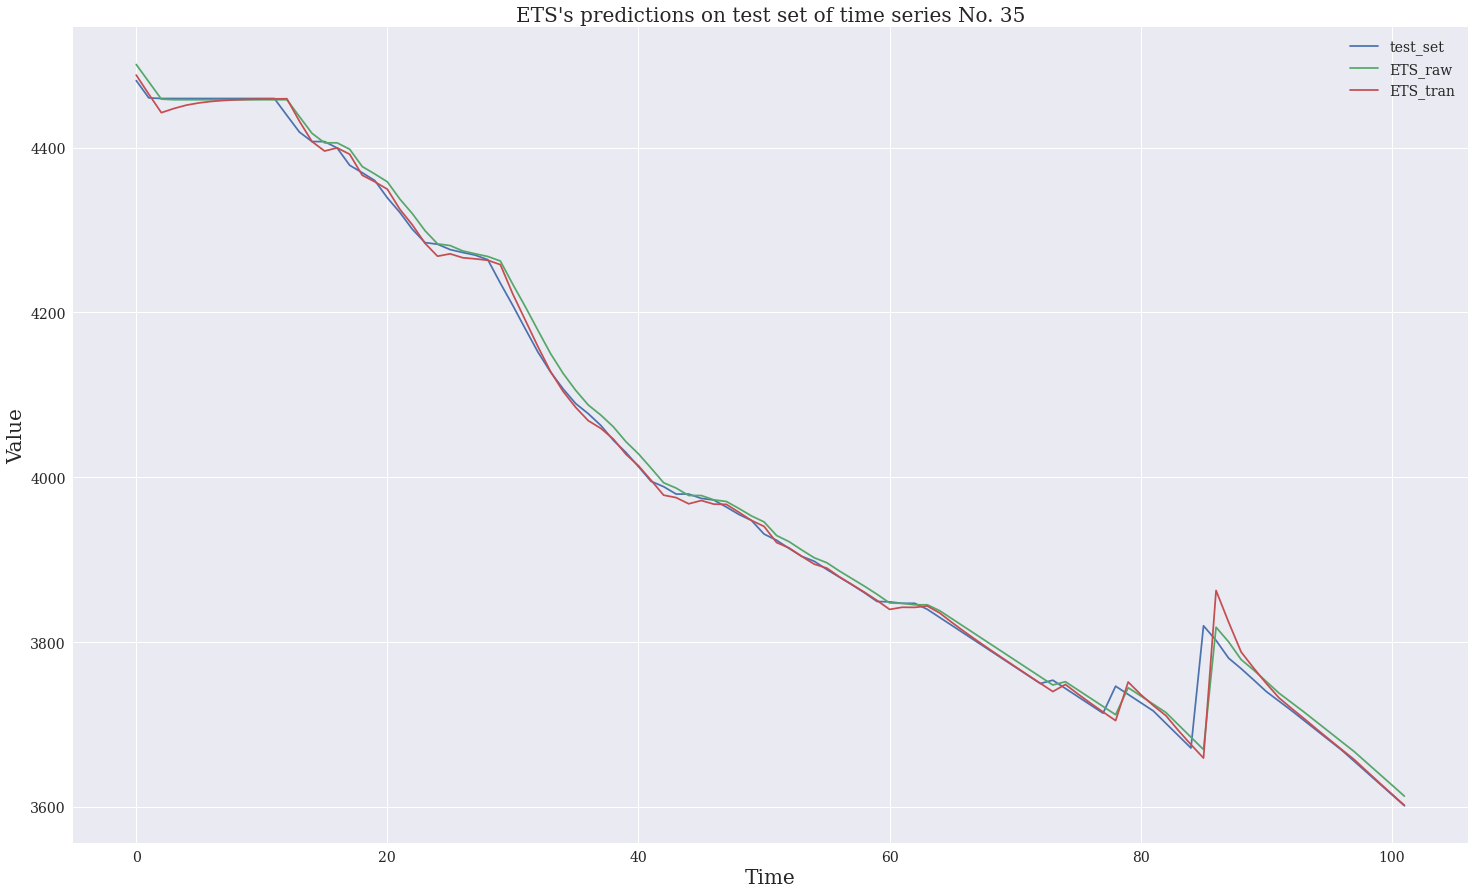

In [14]:
model = 'ETS'
# inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']
score_raw = agent_infos[f'{model}_raw'][use]['test SMAPE']
score_tran = agent_infos[f'{model}_tran'][use]['test SMAPE']

reduce = round((score_raw - score_tran)/score_raw * 100, 4)
print(f'tran generates {reduce}% less error')

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on test set of time series No. {use}', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

In [15]:
use = '3114'

In [16]:
# filter out the test set

test_size = 0.1
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

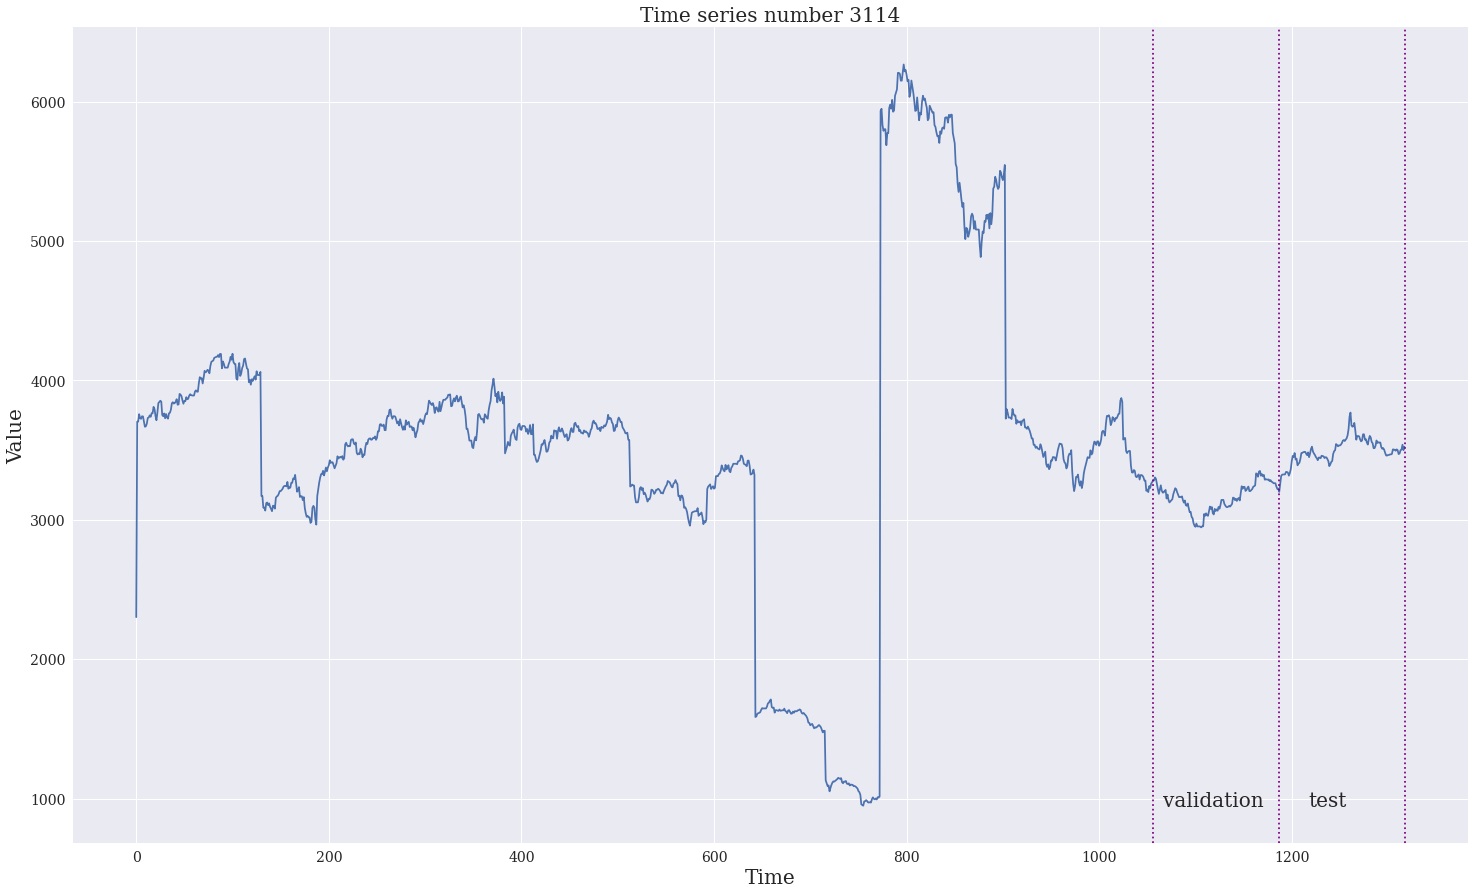

In [17]:
length = len(ts[use])

plt.figure(figsize=(25, 15))
plt.plot(ts[use])
plt.axvline(x=length-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count-test_set_count+10, min(ts[use]), 'validation', fontdict=font)
plt.axvline(x=length-test_set_count-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count+30, min(ts[use]), 'test', fontdict=font)
plt.axvline(x=length, ls=':', color='purple')
plt.title(f'Time series number {use}', fontdict=font)
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

tran generates 27.0157% less error


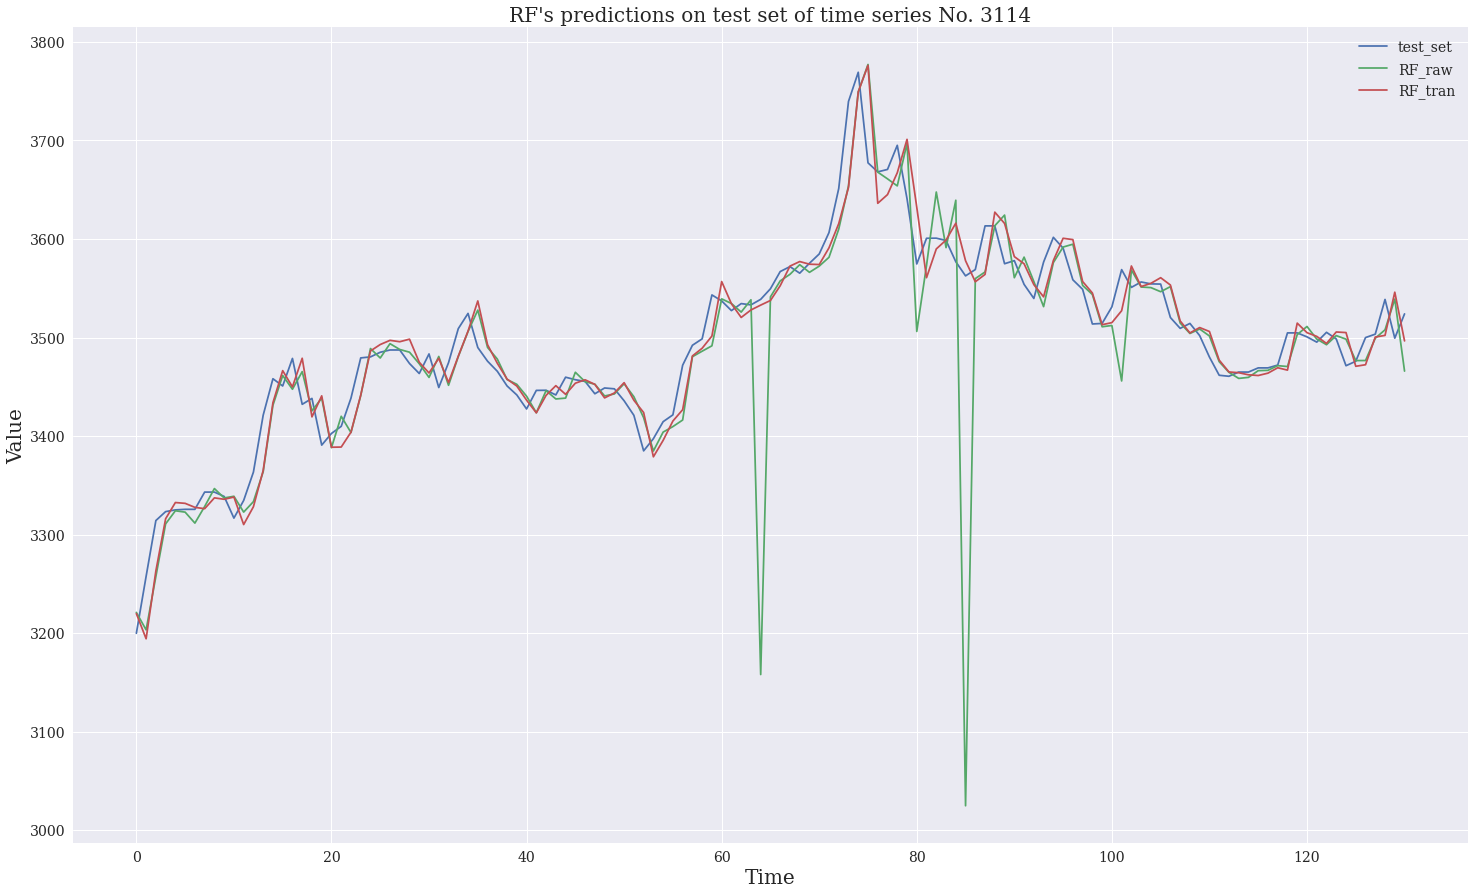

In [19]:
model = 'RF'
# inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']
score_raw = agent_infos[f'{model}_raw'][use]['test SMAPE']
score_tran = agent_infos[f'{model}_tran'][use]['test SMAPE']

reduce = round((score_raw - score_tran)/score_raw * 100, 4)
print(f'tran generates {reduce}% less error')

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on test set of time series No. {use}', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

In [24]:
use = '69'

In [25]:
# filter out the test set

test_size = 0.1
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

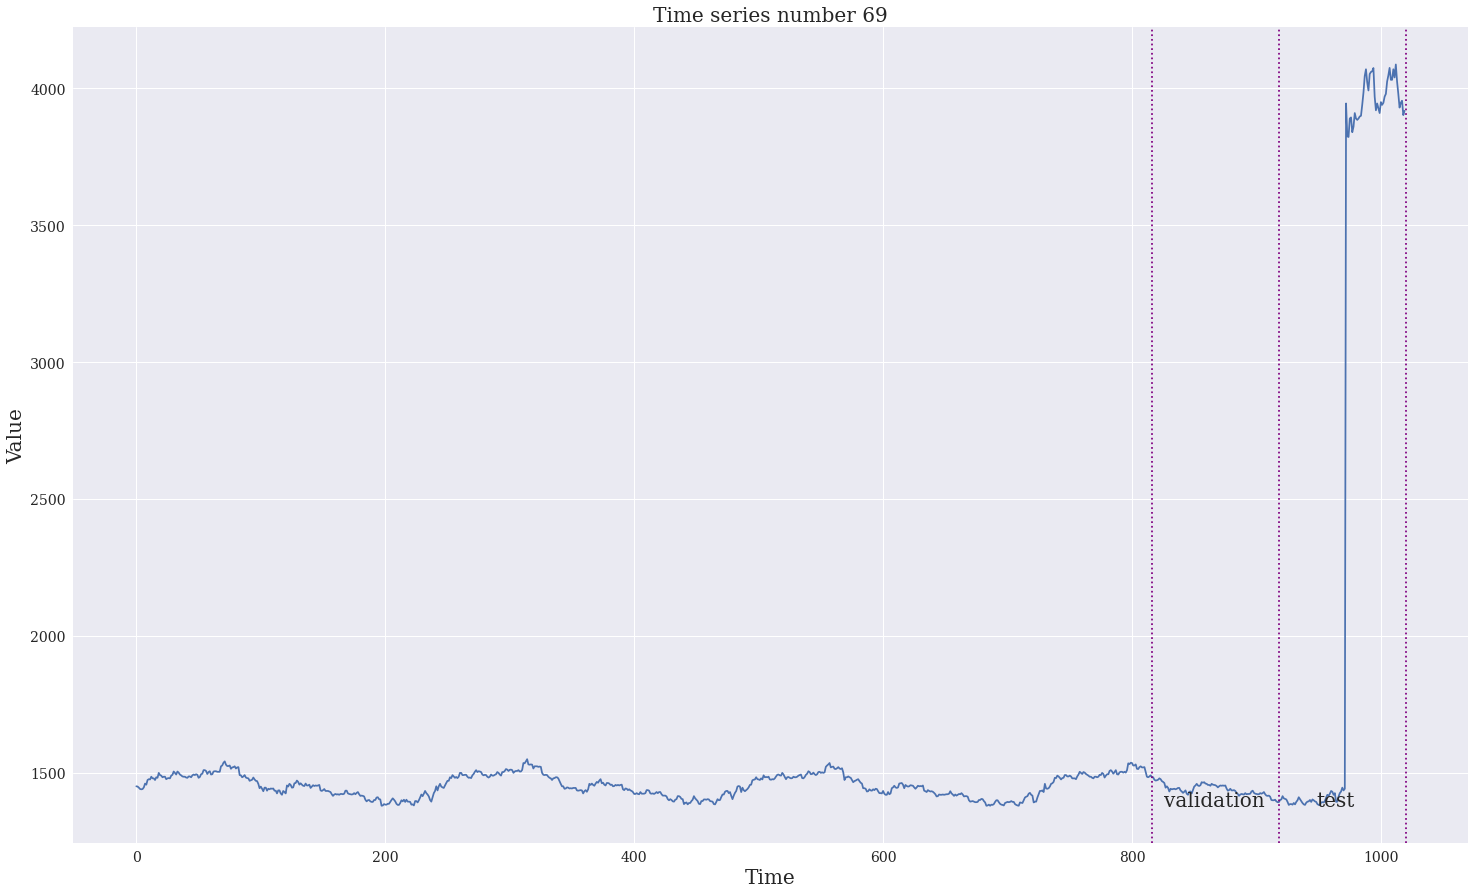

In [26]:
length = len(ts[use])

plt.figure(figsize=(25, 15))
plt.plot(ts[use])
plt.axvline(x=length-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count-test_set_count+10, min(ts[use]), 'validation', fontdict=font)
plt.axvline(x=length-test_set_count-test_set_count, ls=':', color='purple')
plt.text(length-test_set_count+30, min(ts[use]), 'test', fontdict=font)
plt.axvline(x=length, ls=':', color='purple')
plt.title(f'Time series number {use}', fontdict=font)
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

tran generates 54.6662% less error


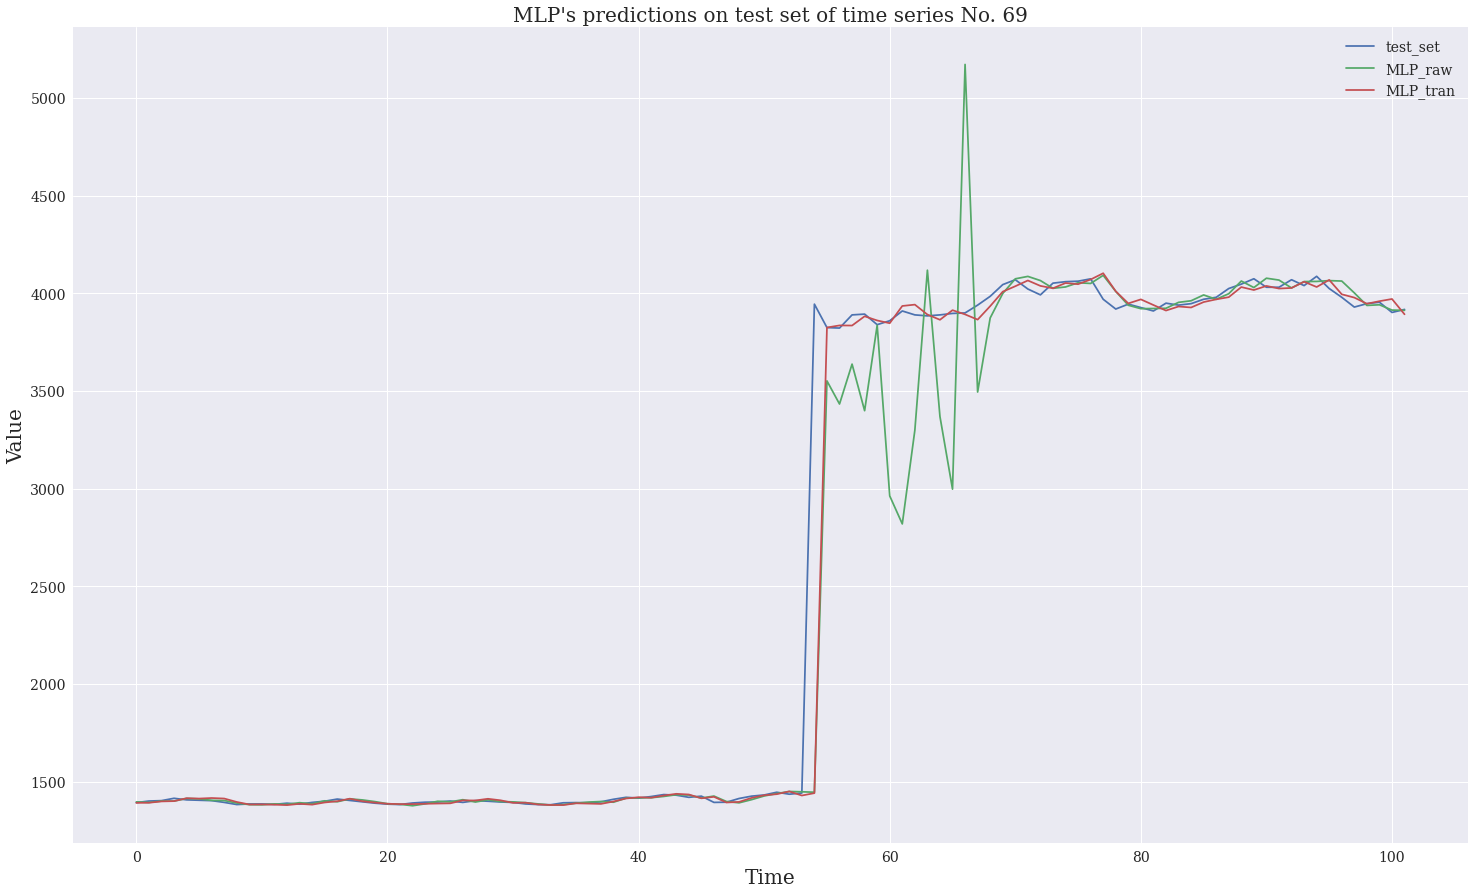

In [27]:
model = 'MLP'
# inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']
score_raw = agent_infos[f'{model}_raw'][use]['test SMAPE']
score_tran = agent_infos[f'{model}_tran'][use]['test SMAPE']

reduce = round((score_raw - score_tran)/score_raw * 100, 4)
print(f'tran generates {reduce}% less error')

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on test set of time series No. {use}', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

tran generates -28.8646% less error


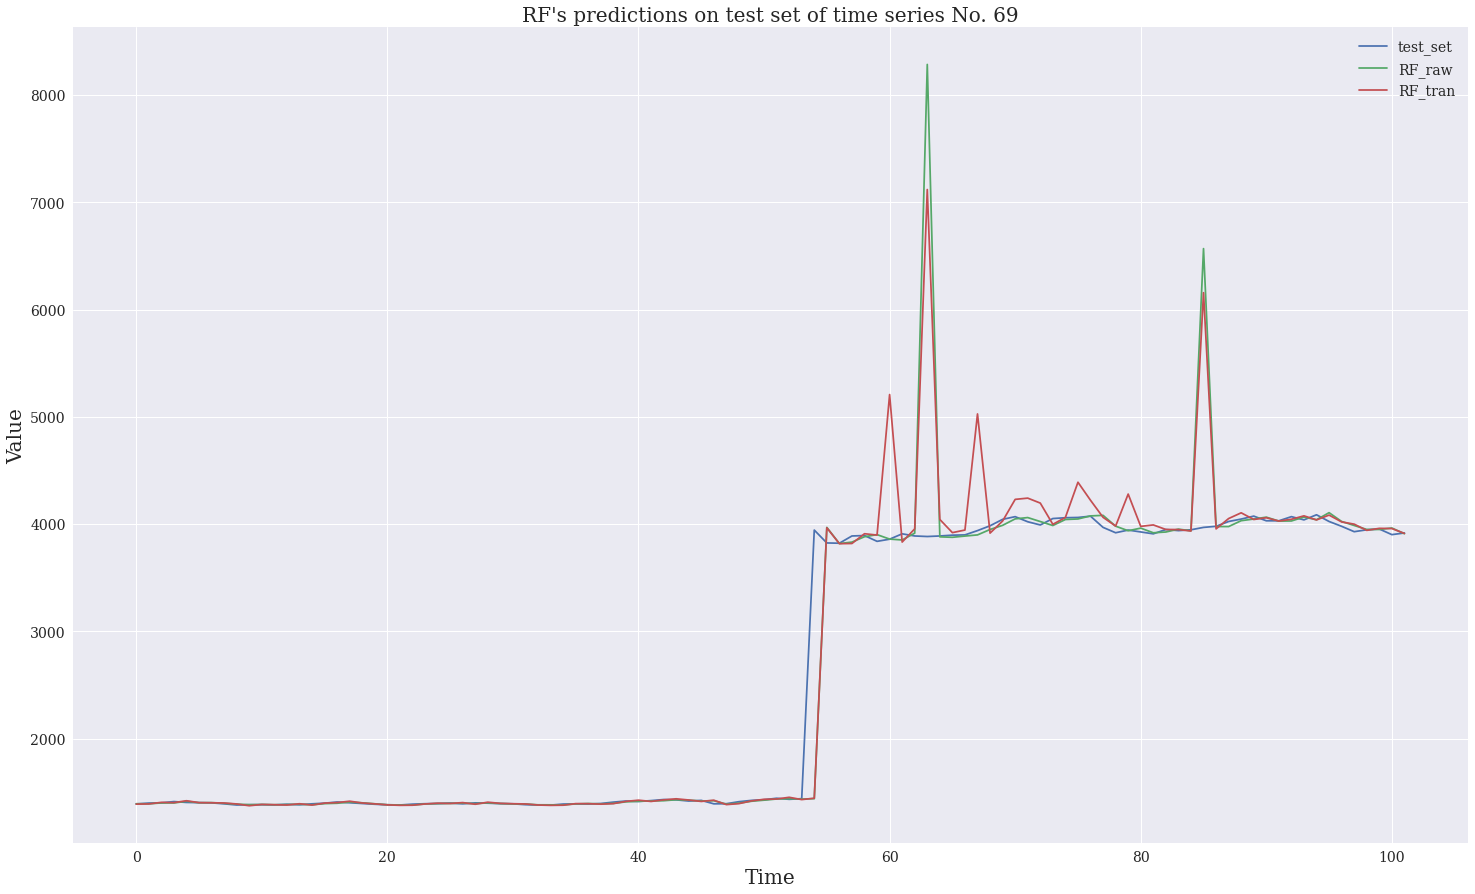

In [28]:
model = 'RF'
# inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']
score_raw = agent_infos[f'{model}_raw'][use]['test SMAPE']
score_tran = agent_infos[f'{model}_tran'][use]['test SMAPE']

reduce = round((score_raw - score_tran)/score_raw * 100, 4)
print(f'tran generates {reduce}% less error')

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on test set of time series No. {use}', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In addition to SMAPE, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [22]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [23]:
numbers = {
    agent: {
        'SMAPEs': [],
        'SMAPEs 1': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['SMAPEs 1'].append((series, play_info['test SMAPE']))
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = round(np.mean(numbers[agent]['SMAPEs']), 6)
    stats[agent]['std. SMAPE'] = round(np.std(numbers[agent]['SMAPEs']), 6)
    stats[agent]['mean ranking'] = round(np.mean(numbers[agent]['rankings']), 3)
    stats[agent]['std. ranking'] = round(np.std(numbers[agent]['rankings']), 3)

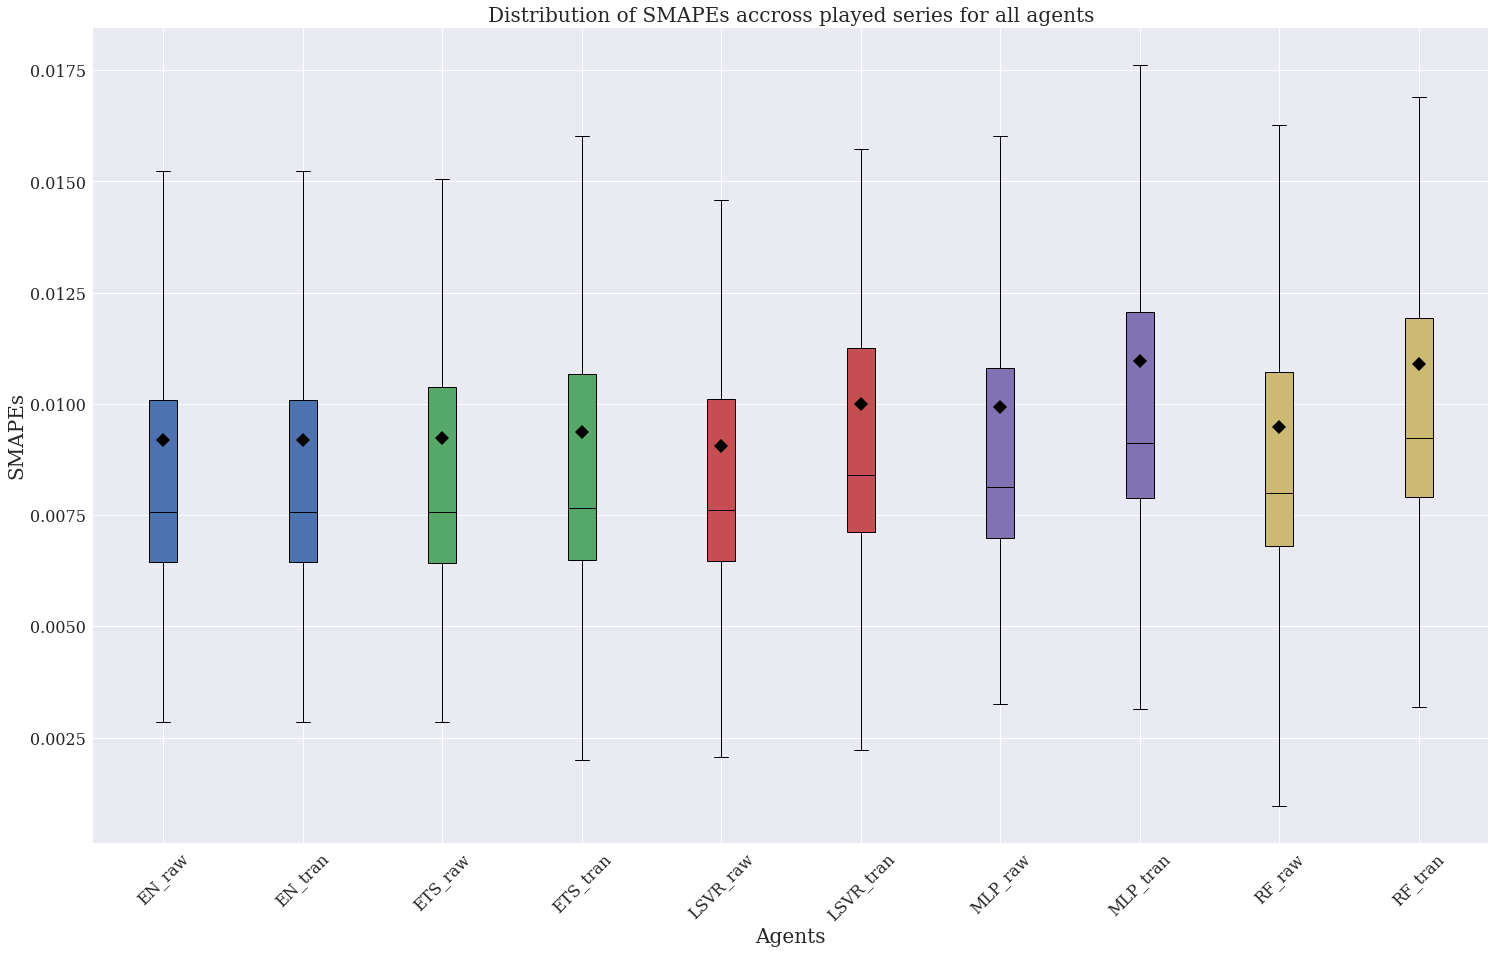

In [37]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [agent['SMAPEs'] for agent in numbers.values()],
    showbox=True,
    showfliers=False,
    labels=list(numbers.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//2))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents', fontdict=font)
plt.xlabel('Agents', fontdict=font)
plt.ylabel('SMAPEs', fontdict=font)
plt.xticks(rotation=45, fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.show()

## Ranking of the agents

In this section, treating the ranking of the agents as a variable, we compute the alpha-confidence interval of the rankings for the agents.

In [25]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 3), round(mean_R+stat, 3)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LSVR_raw,LSVR_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.009179,0.009186,0.009236,0.009377,0.009059,0.009997,0.009934,0.01097,0.009471,0.010889
std. SMAPE,0.00977,0.009906,0.010134,0.010207,0.007686,0.0107,0.008717,0.010123,0.008224,0.010496
mean ranking,2.357,2.317,3.206,4.135,3.548,7.302,6.948,9.115,5.968,9.179
std. ranking,1.285,1.267,1.57,1.941,1.924,1.326,1.802,1.109,1.898,1.163
90% ranking confi. limits,"(2.258, 2.456)","(2.218, 2.416)","(3.107, 3.305)","(4.036, 4.234)","(3.449, 3.647)","(7.203, 7.401)","(6.849, 7.047)","(9.016, 9.214)","(5.869, 6.067)","(9.08, 9.278)"


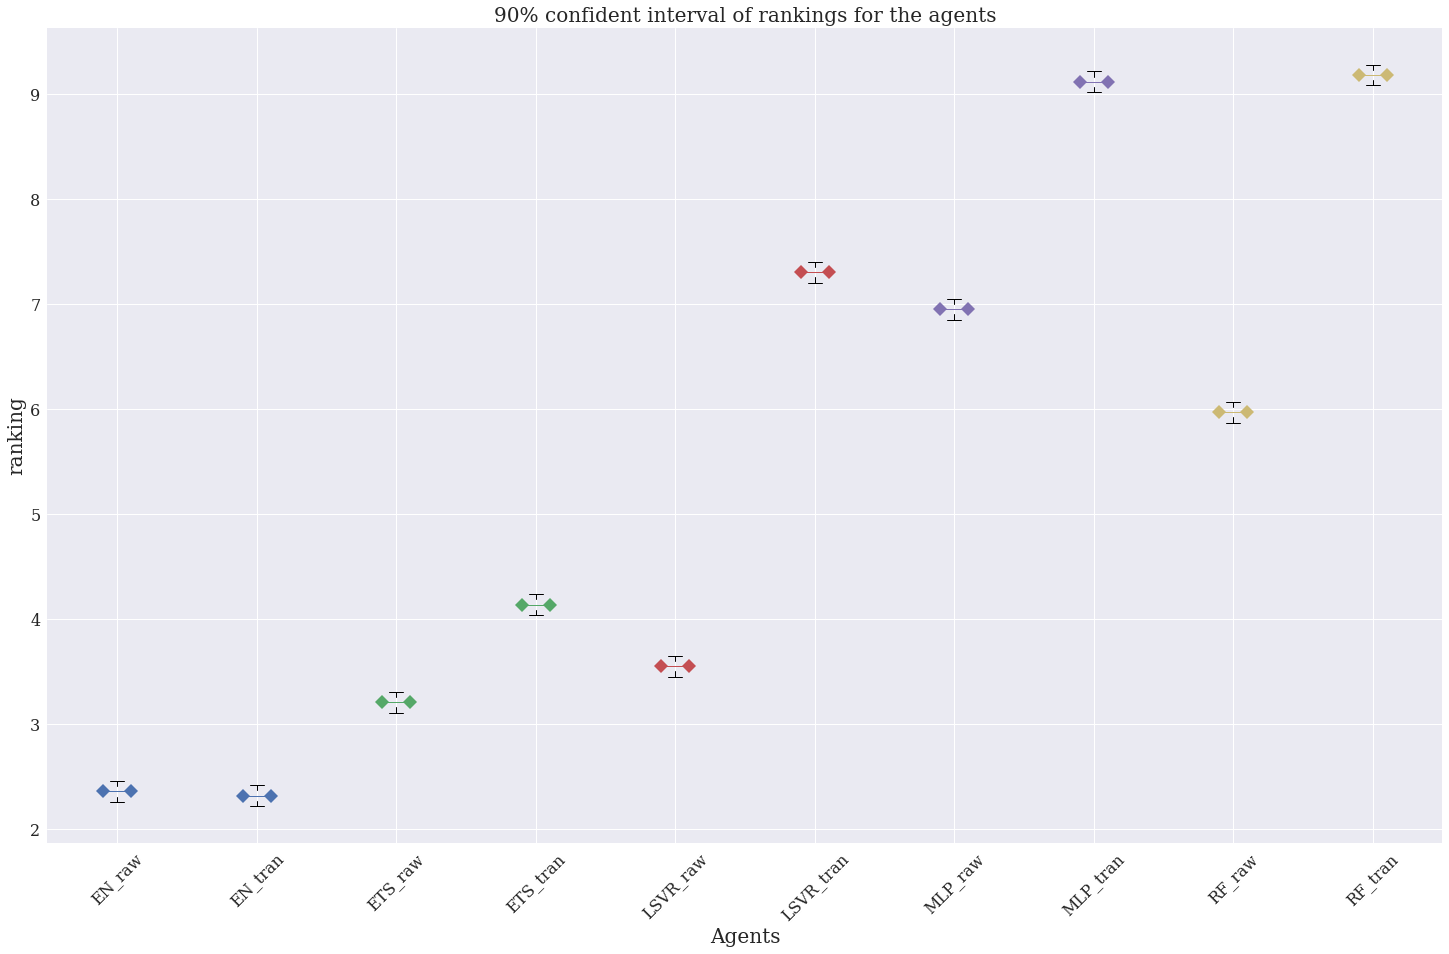

In [26]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//2))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents', fontdict=font)
plt.xlabel('Agents', fontdict=font)
plt.ylabel('ranking', fontdict=font)
plt.xticks(rotation=45, fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.show()

## Fraction best

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

The results are shown in the last row of the table.

In [27]:
for agent, play_info in stats.items():
    play_info['frac best'] = round(np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran, 3)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LSVR_raw,LSVR_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.009179,0.009186,0.009236,0.009377,0.009059,0.009997,0.009934,0.01097,0.009471,0.010889
std. SMAPE,0.00977,0.009906,0.010134,0.010207,0.007686,0.0107,0.008717,0.010123,0.008224,0.010496
mean ranking,2.357,2.317,3.206,4.135,3.548,7.302,6.948,9.115,5.968,9.179
std. ranking,1.285,1.267,1.57,1.941,1.924,1.326,1.802,1.109,1.898,1.163
90% ranking confi. limits,"(2.258, 2.456)","(2.218, 2.416)","(3.107, 3.305)","(4.036, 4.234)","(3.449, 3.647)","(7.203, 7.401)","(6.849, 7.047)","(9.016, 9.214)","(5.869, 6.067)","(9.08, 9.278)"
frac best,0.266,0.298,0.175,0.123,0.298,0.004,0.024,0.0,0.075,0.0


In [28]:
print(leaderboard.T.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
{} & mean SMAPE & std. SMAPE & mean ranking & std. ranking & 90\% ranking confi. limits & frac best \\
\midrule
EN\_raw    &   0.009179 &    0.00977 &        2.357 &        1.285 &            (2.258, 2.456) &     0.266 \\
EN\_tran   &   0.009186 &   0.009906 &        2.317 &        1.267 &            (2.218, 2.416) &     0.298 \\
ETS\_raw   &   0.009236 &   0.010134 &        3.206 &         1.57 &            (3.107, 3.305) &     0.175 \\
ETS\_tran  &   0.009377 &   0.010207 &        4.135 &        1.941 &            (4.036, 4.234) &     0.123 \\
LSVR\_raw  &   0.009059 &   0.007686 &        3.548 &        1.924 &            (3.449, 3.647) &     0.298 \\
LSVR\_tran &   0.009997 &     0.0107 &        7.302 &        1.326 &            (7.203, 7.401) &     0.004 \\
MLP\_raw   &   0.009934 &   0.008717 &        6.948 &        1.802 &            (6.849, 7.047) &     0.024 \\
MLP\_tran  &    0.01097 &   0.010123 &        9.115 &        1.109 &            (9.0

/var/folders/b_/yw5x7f6n2vjcl0smtcw7qjf80000gn/T/ipykernel_60108/2731369229.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(leaderboard.T.to_latex(index=True))


# Series by series comparison between raw and tran agents

In [29]:
played_by_all = list(played_by_all)
compare = {
    'EN': {},
    'ETS': {},
    'LSVR': {},
    'MLP': {},
    'RF':{}
}

values = {
    'EN': {},
    'ETS': {},
    'LSVR': {},
    'MLP': {},
    'RF': {}
}

for model in compare:
    compare[model] = {
        'Avg. reduction': 0,
        'Std. reduction': 0,
        '+ reduction ratio': 0,
        'Avg. + reduction': 0,
        'Std. + reduction': 0
    }

    values[model] = {
        'compares': [],
        'beats ind': [],
        'beats': []
    }

    for i, (r, t) in enumerate(zip(numbers[f'{model}_raw']['SMAPEs 1'], numbers[f'{model}_tran']['SMAPEs 1'])):
        comp = round((r[1] - t[1])/r[1] * 100, 2)
        values[model]['compares'].append(comp)
        if comp > 0:
            values[model]['beats ind'].append(r[0])
            values[model]['beats'].append(comp)
    
    compare[model]['Avg. reduction'] = round(np.mean(values[model]['compares']), 2)
    compare[model]['Std. reduction'] = round(np.std(values[model]['compares']), 2)
    compare[model]['Avg. + reduction'] = round(np.mean(values[model]['beats']), 2)
    compare[model]['Std. + reduction'] = round(np.std(values[model]['beats']), 2)
    compare[model]['+ reduction ratio'] = round(100 * len(values[model]['beats'])/len(values[model]['compares']), 2)


In [30]:
comp_board = pd.DataFrame(compare)
comp_board.T

,Avg. reduction,Std. reduction,+ reduction ratio,Avg. + reduction,Std. + reduction
EN,0.02,0.24,23.41,0.12,0.44
ETS,-1.13,3.87,30.95,0.66,3.37
LSVR,-9.00,5.70,3.17,1.86,1.12
MLP,-12.04,17.01,11.51,11.25,10.02
RF,-15.09,12.60,3.57,9.61,7.89


In [31]:
print(comp_board.T.to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Avg. reduction &  Std. reduction &  + reduction ratio &  Avg. + reduction &  Std. + reduction \\
\midrule
EN   &            0.02 &            0.24 &              23.41 &              0.12 &              0.44 \\
ETS  &           -1.13 &            3.87 &              30.95 &              0.66 &              3.37 \\
LSVR &           -9.00 &            5.70 &               3.17 &              1.86 &              1.12 \\
MLP  &          -12.04 &           17.01 &              11.51 &             11.25 &             10.02 \\
RF   &          -15.09 &           12.60 &               3.57 &              9.61 &              7.89 \\
\bottomrule
\end{tabular}



/var/folders/b_/yw5x7f6n2vjcl0smtcw7qjf80000gn/T/ipykernel_60108/3958334984.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(comp_board.T.to_latex(index=True))


In [32]:
for m, v in values.items():
    print(f'{m} best improve')
    print(v['beats ind'][np.argmax(v['beats'])], max(v['beats']))

EN best improve
33 2.75
ETS best improve
35 29.89
LSVR best improve
3212 3.09
MLP best improve
69 54.67
RF best improve
3114 27.02


In [33]:
improve_set = []
for m, v in values.items():
    improve_set += v['beats ind']

improve_set = list(set(improve_set))
improve_set

['1361',
 '19',
 '1346',
 '2502',
 '63',
 '454',
 '606',
 '99',
 '650',
 '1349',
 '17',
 '1351',
 '1357',
 '2590',
 '14',
 '2576',
 '2975',
 '2553',
 '640',
 '100',
 '583',
 '2753',
 '1000',
 '2315',
 '577',
 '2370',
 '1355',
 '600',
 '3359',
 '645',
 '597',
 '609',
 '2595',
 '610',
 '598',
 '2440',
 '111',
 '3114',
 '991',
 '15',
 '986',
 '1362',
 '102',
 '2902',
 '118',
 '6',
 '602',
 '642',
 '13',
 '2078',
 '1358',
 '3115',
 '1603',
 '1360',
 '607',
 '2974',
 '3196',
 '130',
 '3213',
 '3358',
 '554',
 '5',
 '591',
 '3131',
 '3469',
 '2624',
 '2756',
 '633',
 '634',
 '596',
 '32',
 '573',
 '3548',
 '2551',
 '571',
 '2439',
 '2625',
 '3038',
 '2484',
 '2779',
 '656',
 '3212',
 '54',
 '652',
 '112',
 '590',
 '3235',
 '993',
 '2044',
 '3120',
 '117',
 '601',
 '2580',
 '603',
 '1345',
 '657',
 '594',
 '604',
 '995',
 '3470',
 '1005',
 '3357',
 '110',
 '1359',
 '2592',
 '574',
 '2485',
 '35',
 '653',
 '578',
 '2425',
 '3121',
 '1348',
 '605',
 '2622',
 '3511',
 '636',
 '586',
 '1350',
 '2

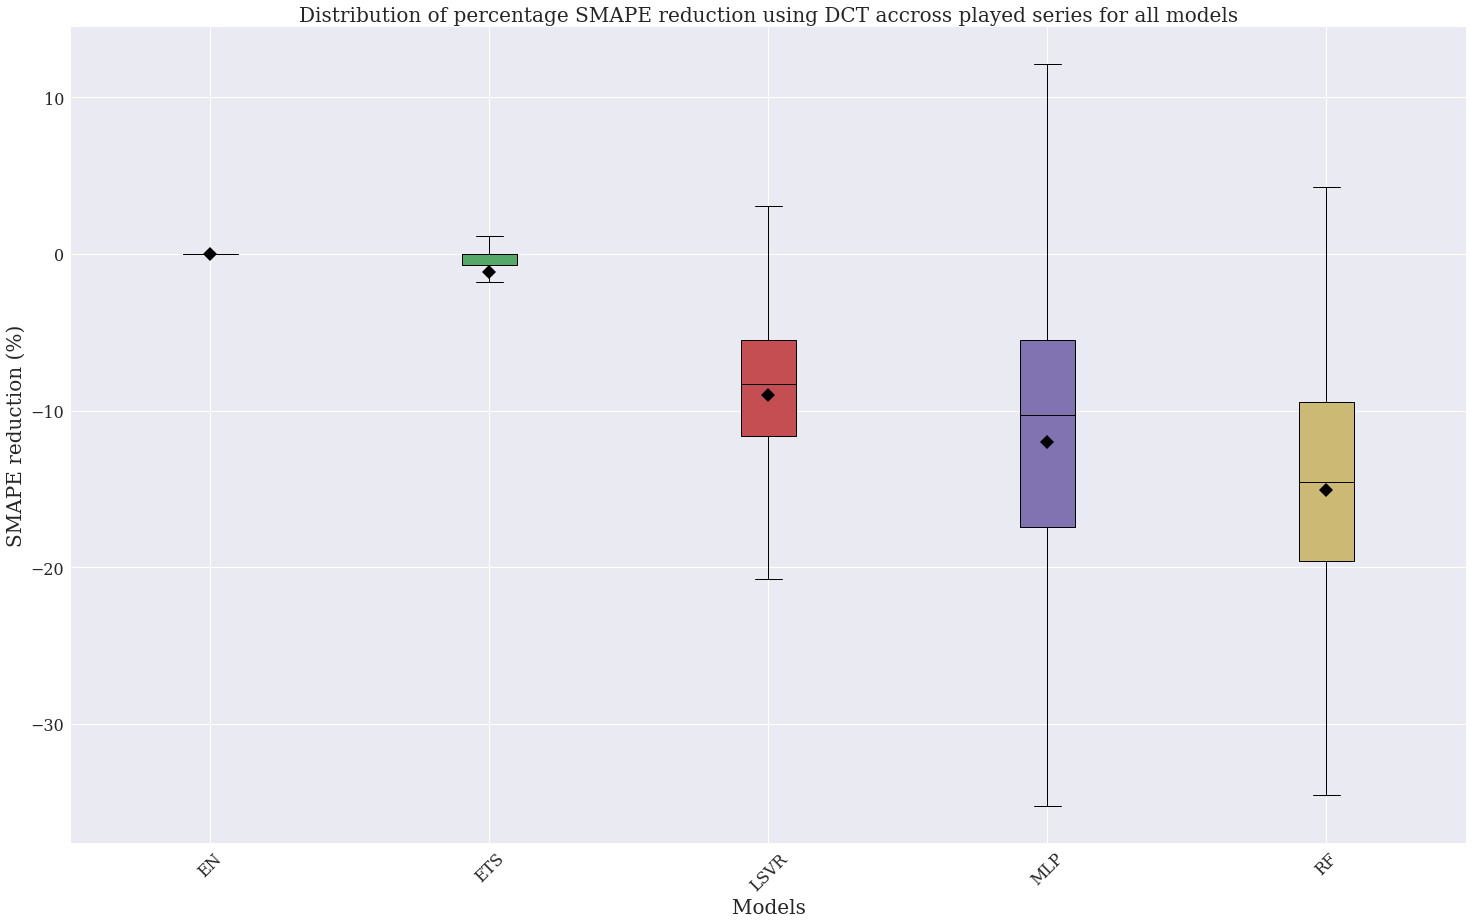

In [34]:
plt.figure(figsize= (25, 15))
n_agents = len(list(values.keys()))
colors = [f'C{i}' for i in range(n_agents//1)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [v['compares'] for v in values.values()],
    showbox=True,
    showfliers=False,
    labels=list(values.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//1))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of percentage SMAPE reduction using DCT accross played series for all models', fontdict=font)
plt.xlabel('Models', fontdict=font)
plt.ylabel('SMAPE reduction (%)', fontdict=font)
plt.xticks(rotation=45, fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.show()

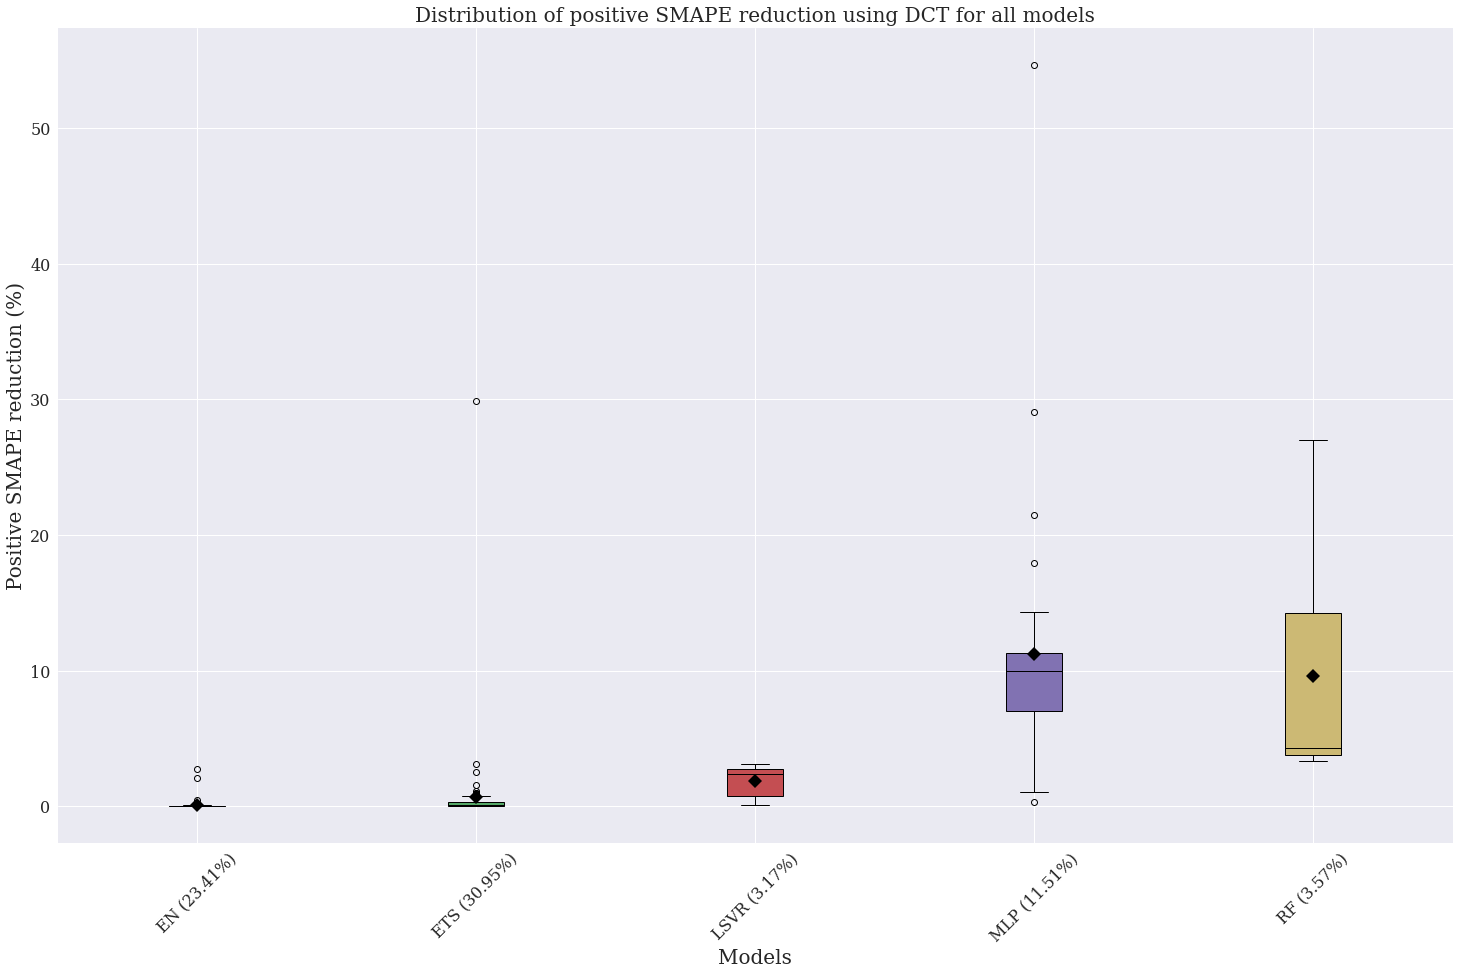

In [35]:
plt.figure(figsize= (25, 15))
n_agents = len(list(values.keys()))
colors = [f'C{i}' for i in range(n_agents//1)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)
k = '+ reduction ratio'
box = plt.boxplot(
    [v['beats'] for v in values.values()],
    showbox=True,
    showfliers=True,
    labels=[f'{m} ({v[k]}%)' for m, v in compare.items()],
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//1))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of positive SMAPE reduction using DCT for all models', fontdict=font)
plt.xlabel('Models', fontdict=font)
plt.ylabel('Positive SMAPE reduction (%)', fontdict=font)
plt.xticks(rotation=45, fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.show()

<Figure size 1800x1080 with 0 Axes>

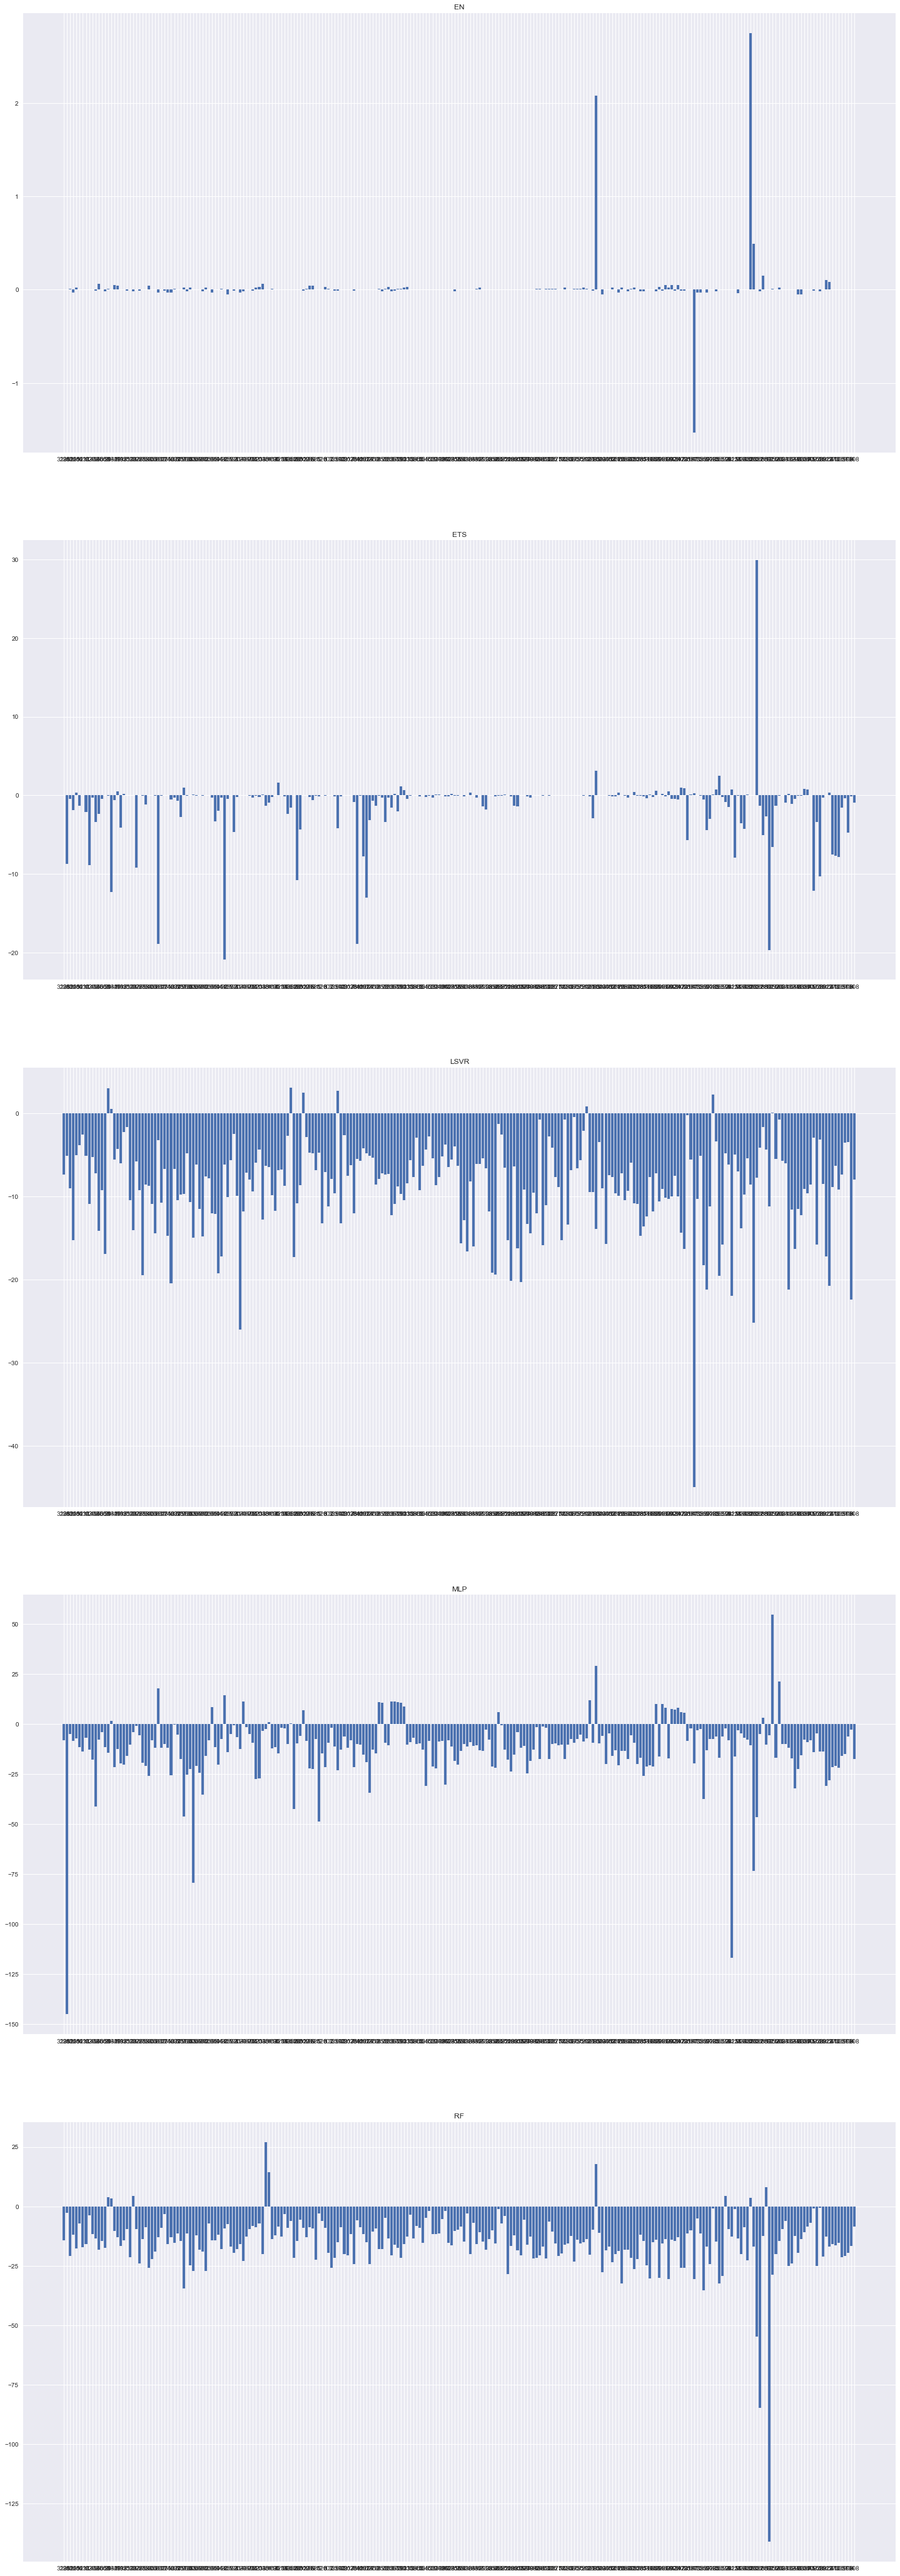

In [36]:
plt.figure(figsize=(25, 15))
fig, axs = plt.subplots(nrows = 5, ncols = 1, figsize = (25, 75))
for i, m in enumerate(compare.keys()):
    axs[i].bar(played_by_all, values[m]['compares'])
    axs[i].set_title(f'{m}')
plt.show()

# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.